# DataCleaning (Class Data)

In [1]:
#import required modules:
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import os
from sklearn.preprocessing import RobustScaler
import copy

plt.style.context('dark_background')
plt.rcParams.update(plt.rcParamsDefault)


## <span style=color:#7fc97f>Description of the Class Data</span>
#### The class has 2 inputs: A Pandas DataFrame and a name:

--> To create an instance ot the Class Data, use following lines:
```json
dataframe = pd.read_csv("PATH TO DATA")
name="DESIRED NAME"
LakeAegeri=Data(dataframe,name)
```
<br>
<br>

#### <span style=color:#7fc97f>The Class has various methods:</span> <br>
#####  <span style=color:#386cb0>1. The INSTANCE_CLASS_DATA.calc_rolling_statistics(column,window,plot="n",save_plot="n")</span>
This method will calculate the rolling statistics and outputs a plot.

If you don't want the plot plotted in the notebook, use show_plot="n".

If you want to save the plot in the /data/output/.. folder:
- save_plot="y" -> It asks you to input a name without a space.
- save_plot="CUSTOM_NAME" -> It creates a plot with the name CUSTOM_NAME in the specified folder
- save_plot="n": It will not save the created figure
If you want to define the rolling window, use window=INTEGER
<br>
<br>

##### <span style=color:#386cb0>2. The INSTANCE_CLASS_DATA.check_stationarity(column):</span>
This method will check the stationarity using the Augmented Dickey-Fuller Test (ADF). As an input use the column you want the stationarity checked on.
We dont need this method.
<br>
<br>

##### <span style=color:#386cb0>3. INSTANCE_CLASS_DATA.detect_outlier(self, column, pchip_imputation="y", PERIOD=24, display_plots="y"):</span>

This method will clean the data with help of the seasonal decomposition of the specified column (column=COLUMN_NAME).<br>

The method returns an instance of the class Data (with the whole DataFrame with the (timeseries) cleaned column). The physical impossible outliers are not cleaned in this method.<br>

If you want the more "fancy" PChip (Piecewise Cubic Hermite Interpolating Polynomial) Imputation, use pchip_imputation="y". It looks at outlier and puts a mathematical function over the dataset. The method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. Spline interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately. Otherwise, use pchip_imputation="n" to use the simple imputer: It looks at the normalized residuals and sets >3 values to 3 and <-3 values to -3. In the last step. If you want to delete the outliers, use pchip_imputation="delete". Note, that many data is lost due to this process, because it will delete the entire column.<br>

PERIOD: If you want to change the period of the data, change the PERIOD parameter.<br>

Display plots in the notebook: If you want to display the plots, use display_plots="y", else display_plots="n"
<br>
<br>

##### <span style=color:#386cb0>4. INSTANCE_CLASS_DATA.remove_outliers_temperature(self, skin_column_name="y", bulk_column_name="y1", airtemp_column_name="air_temp", imputation="y"):</span>

This method will clean the physically impossible outliers of the skin, bulk and air temperatures.

skin_column_name="XXX" : input the name of the skin temperature column
bulk_column_name="XXX" : input the name of the bulk temperature column
airtemp_column_name="XXX" : input the name of the air temperature column

imputation="y": If you want the physically impossible values imputed, make imputation="y". The imputation method is the PChip (Piecewise Cubic Hermite Interpolating Polynomial) method. It looks at outlier and puts a mathematical function over the dataset. The method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. Spline interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately.
imputation="n": If you want the physically impossible values deleted, use imputation="n". Note, that many data is lost due to this process, because it will delete the entire column.
<br>
<br>

##### <span style=color:#386cb0>5. Instance_CLASS_DATA.remove_outliers_static(self, column_name, imputation="y"):</span>

This method will remove the statistical outliers of a column. Note, that this column will not look at the seasonality in the data, and will use the normalized values of the selected column (column_name="XXX") to determine the outliers.

If the Z-Score (COLUMN_VALUE-mean/std) exceeds 3 (or -3), the point will be considered as an outlier.
-> If you want to impute the missing data with the Splines Imputation, use imputation = "y", else imputation = "n". The  PChip (Piecewise Cubic Hermite Interpolating Polynomial) Imputation looks at the missing points (here the outliers) and puts a mathematical function over the dataset. The method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points.  PChip interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately.
<br>
<br>

##### <span style=color:#386cb0>6. Instance_CLASS_DATA.rename_columns(self,columns={"y": "skin_temp", "y1": "bulk_temp"}): </span>

This method will rename the columns of the instance. With a dictionary, the columns can be added by {"name_before":"name_after",...}
<br>
<br>

##### <span style=color:#386cb0>7. Instance_CLASS_DATA.create_histogram(self,column_name): </span>
This method creates a histogram from the selected column. It also adds the Kernel Denstity Estimation (KDE) onto the histogram.
<br>
<br>

##### <span style=color:#386cb0>8. create_paiplot(self,column_names=[]) </span>
This method will create a pairplot of the selected columns (column_names=["column1","column2",...]). <br> If the parameter column_names is not defined, the whole dataset will be plotted as a pairplot.
<br>
<br>


In [2]:
class Data:
    def __init__(self, dataframe, name, set_index_datetime_int="y"):
        self.name = name
        self.dataframe = dataframe
        #convert the strings and add the datetime column to index
        self.dataframe["datetime"] = pd.to_datetime(self.dataframe["datetime"])

        index_name = self.dataframe.index.name  #this is used further below in the else: statement
        self.dataframe = self.dataframe.reset_index()

        if set_index_datetime_int == "y":
            self.dataframe.index = self.dataframe["x"]
            self.dataframe = self.dataframe.drop(columns=["x", "index"])
        else:
            self.dataframe.index = self.dataframe[index_name]
            self.dataframe = self.dataframe.drop(columns=[index_name])

        self.columns = self.dataframe.columns

    def __repr__(self):
        return f"DataFrame {name} with columns: {str(list(self.columns))}"

    def calc_rolling_statistics(self, column, window, show_plot="no", save_plot="no"):
        mean_rm = self.dataframe[column].rolling(window=window).mean()
        std_rm = self.dataframe[column].rolling(window=window).std()

        plt.style.context
        plt.rc('figure', figsize=(10, 6))
        fig, ax = plt.subplots(1, sharex=False, sharey=False)
        ax.plot(self.dataframe["datetime"], self.dataframe[column], color='#e31a1c', label='Actual', alpha=0.7)
        ax.plot(self.dataframe["datetime"], mean_rm, color='#b2df8a', label=f'Rolling Mean (window: {window})',
                alpha=0.7)
        ax.plot(self.dataframe["datetime"], std_rm, color='#1f78b4', label=f'Rolling Std (window: {window})', alpha=0.7)
        plt.legend(loc='best')
        plt.title(f'Rolling Mean & Standard Deviation of {column}')

        if save_plot == "y":
            plt.savefig(f"./data/output_png/{input('How should the figure be named? (no Spaces!)')}.png")
        elif save_plot != "no":
            plt.savefig(f"./data/output_png/{save_plot}.png")

        if show_plot == "n":
            plt.close()
        plt.show(block=False)

    def check_stationarity(self, column):
        print(f"Visual check is advised with {self.name}.calc_rolling_statsitics(...,plot='Y')")
        print(
            "->  A stationary Time Series is one which characteristics like mean and variance does not change over time.")
        print(
            "Another way of checking for stationarity of the time series is using Augmented Dickey-Fuller (ADF) Test to check stationarity:")
        print("--------------------")
        print('Dickey-Fuller Test: ')
        X = self.dataframe[column].dropna().values
        dftest = adfuller(X, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'No. of Obs'])
        for key, value in dftest[4].items():
            dfoutput['Critical Value (%s)' % key] = value

        if list(dfoutput.items())[1][1] > 0.05:
            print(
                f"with a p-value of {round(list(dfoutput.items())[1][1], 3)}, we fail to reject the null hypothesis, that the data is stationary.")
            print(dfoutput)
            return False
        else:
            print(
                f"with a p-value of {round(list(dfoutput.items())[1][1], 3)}, we reject the null hypothesis, that the data is stationary.")
            print(dfoutput)

    def detect_outlier(self, column, pchip_imputation="y", PERIOD=24, display_plots="y"):
        ### 1. Prepare Dataset for the seasonal seasonal_decompose function:
        pd.set_option('display.max_rows', None)
        dataframe_noNAN = self.dataframe.dropna()
        dataframe_noNAN = dataframe_noNAN.reset_index()
        dataframe_noNAN = dataframe_noNAN.set_index("datetime")

        #set plot size:
        plt.rc('figure', figsize=(10, 6))
        plt.rc('font', size=10)

        ### 2. Seasonal decompose
        result = seasonal_decompose(dataframe_noNAN[[column]], period=PERIOD, model="additive")

        #plot the seseasonal_decompose:
        fig, ax = plt.subplots(4, sharex=False, sharey=False)
        fig.subplots_adjust(bottom=7, top=9)

        ax[0].plot(result.observed, color="#a6cee3", linewidth=1)
        ax[0].set_title("Result observed")

        ax[1].plot(result.seasonal, color="#b2df8a", linewidth=1)
        ax[1].set_title(f"seasonality of Period {PERIOD}")

        ax[2].plot(result.trend, color="#fb9a99", linewidth=1)
        ax[2].set_title("Trend")

        ax[3].plot(result.resid, color="#fdbf6f", linewidth=1)
        ax[3].set_title("Residuals")

        if display_plots != "y":
            plt.close()
        plt.show()

        ## 2.1 residuals (imputation yes or no)
        seasonal_df = result.seasonal.to_frame()
        trend_df = result.trend.to_frame()
        residuals_df = result.resid.to_frame()

        # 2.1.1 Normalize residuals:
        mean = residuals_df.mean()
        std = residuals_df.std()
        residuals_df_norm = residuals_df.copy()
        residuals_df_norm = (residuals_df_norm[["resid"]] - mean[0]) / std[0]

        # 2.1.2 If the normalized residuals exceed +/- 3, then this is considered an outlier:
        residuals_df_norm['is_outlier'] = np.where((residuals_df_norm['resid'] > 3) | (residuals_df_norm['resid'] < -3),
                                                   True, False)
        print(
            f"----------------------------------------\n \033[94m{residuals_df_norm['is_outlier'].value_counts()[True]} values (residuals) are dropped/imputed in {column}. \033[0m")

        outliers_detection = residuals_df_norm["is_outlier"]
        outliers_detection = outliers_detection.to_frame(name="is_outlier")
        #plot exceeded residuals:
        fig, ax = plt.subplots()
        ax.scatter(residuals_df_norm.reset_index()["datetime"], residuals_df_norm.reset_index()["resid"],
                   c=residuals_df_norm["is_outlier"], cmap=cm.Set2, s=1)
        ax.axhline(3, color="#e31a1c")
        ax.axhline(-3, color="#e31a1c")
        if display_plots != "y":
            plt.close()
        plt.show()

        # 2.1.3 IMPUTATION: if needed
        if pchip_imputation == "y":
            print(
                f"---> PChip Imputation of {column}. It looks at outlier and puts a mathematical function over the dataset. The method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. PChip interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately.\nThe method returns an instance of the class Data (with the whole DataFrame with the (timeseries) cleaned column {column}). The physical impossible outliers are not cleaned in this method.")
            #IMPUTATION:
            residuals_df_norm = residuals_df_norm.dropna()
            residuals_df_imputed = residuals_df_norm.copy()
            residuals_df_imputed['resid'] = np.where(
                (residuals_df_imputed['resid'] > 3) | (residuals_df_imputed['resid'] < -3), np.nan,
                residuals_df["resid"].dropna())

            residuals_cleaned = residuals_df_imputed[['resid']].interpolate(option="pchip")  #pchip interpolation

        elif pchip_imputation == "delete":
            residuals_cleaned = residuals_df_norm[["resid"]]

        else:  #ASSUMING THAT ALL RESIDUALS WILL BE SET TO 3 or -3 (normalized) WHEN THEY ARE ABOVE 3 OR BELOW -3
            print(
                f"---> Simple imputation of {column}: It looks at the normalized residuals and sets >3 values to 3 and <-3 values to -3.\nThe method returns an instance of the class Data (with the whole DataFrame with the (timeseries) cleaned column {column}). The physical impossible outliers are not cleaned in this method.")

            residuals_df_norm = residuals_df_norm.dropna()
            residuals_df_norm.loc[residuals_df_norm["resid"] > 3, "resid"] = 3
            residuals_df_norm.loc[residuals_df_norm["resid"] < -3, "resid"] = -3
            residuals_df_norm = residuals_df_norm.drop(columns=["is_outlier"])

            # De-Normalize (inverse of residuals_df_norm = (residuals_df_norm[["resid"]] - mean[0])/std[0])
            residuals_cleaned = residuals_df_norm.mul({"resid": std[0]}).add({"resid": mean[0]})

        #Compose the Timeseries again (by adding the components residuals, seasonality and trend)
        fig, ax = plt.subplots()
        ax.scatter(residuals_cleaned.reset_index()["datetime"], residuals_cleaned.reset_index()["resid"], s=1)
        if display_plots != "y":
            plt.close()
        plt.show()

        #merging the timestamps of the 3 DataFrame's
        data_cleaned = residuals_cleaned.join(seasonal_df).join(trend_df)
        data_cleaned[column] = data_cleaned["seasonal"] + data_cleaned["resid"] + data_cleaned["trend"]
        #combine the data_cleaned (with 1 column) with the original dataframe
        temp = self.dataframe.copy()
        temp = temp.reset_index()
        temp = temp.set_index("datetime")
        data_cleaned = data_cleaned.drop(columns=["seasonal", "trend", "resid"]).join(temp, how="left", lsuffix='left',
                                                                                      rsuffix='right')

        del data_cleaned[f"{column}right"]  #delete column

        data_cleaned = data_cleaned.rename(columns={f"{column}left": column})

        data_cleaned["is_outlier"] = outliers_detection["is_outlier"]

        temp = None

        #add Quality / delete:
        if pchip_imputation == "delete":
            data_cleaned = data_cleaned.drop(data_cleaned[data_cleaned["is_outlier"] == True].index)
        else:
            data_cleaned["Quality"] = np.where((data_cleaned['is_outlier'] == True), data_cleaned["Quality"] + 1,
                                               data_cleaned["Quality"])
            data_cleaned.loc[data_cleaned["Quality"] > 1, "Quality"] = 1

        try:
            data_cleaned = data_cleaned.drop(columns=["is_outlier"])
        except:
            pass

        data_cleaned = data_cleaned.reset_index()
        data_cleaned = data_cleaned.set_index("x")
        return Data(data_cleaned, self.name, set_index_datetime_int="n")

    def remove_outliers_temperature(self, skin_column_name="y", bulk_column_name="y1", airtemp_column_name="air_temp",
                                    imputation="y"):

        result_df = self.dataframe.copy()
        # Remove any rows where either "skinTemp" or "bulkTemp" is above 35
        result_df.loc[result_df[skin_column_name] >= 35, skin_column_name] = np.NaN
        result_df.loc[result_df[skin_column_name] <= 0, skin_column_name] = np.NaN

        #https://www.meteoswiss.admin.ch/climate/the-climate-of-switzerland/records-and-extremes (to filter out extremas in air temperature
        result_df.loc[result_df[airtemp_column_name] >= 41.5, airtemp_column_name] = np.NaN
        result_df.loc[result_df[airtemp_column_name] <= -41.8, airtemp_column_name] = np.NaN

        result_df.loc[result_df[bulk_column_name] >= 35, bulk_column_name] = np.NaN
        result_df.loc[result_df[bulk_column_name] <= 0, bulk_column_name] = np.NaN

        print(
            f"----------------------------------------\n \033[94m{result_df[skin_column_name].isna().sum()} values are dropped/imputed in skin temperature of {self.name}.\n{result_df[bulk_column_name].isna().sum()} values are dropped/imputed in bulk temperature  of {self.name}.\n{result_df[airtemp_column_name].isna().sum()} values are dropped/imputed in air temperature  of {self.name}. \033[0m")

        if imputation == "y":
            #implement IMPUTATION here
            print(
                f"---> PChip interpolation Imputation of skin and bulk temperature: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. \nThe function returns a (Physical) cleaned DataFrame with the columns airtemp, skin & bulk temperature (physicaly) cleaned. The other parameters are not yet cleaned.")

            #IMPUTATION SPLINES Imputer:
            result_df["Quality"] = result_df.get("Quality", 0)
            result_df["Quality"] = np.where((result_df.isna().any(axis=1)), result_df["Quality"] + 1,
                                            result_df["Quality"])
            result_df.loc[result_df["Quality"] > 1, "Quality"] = 1
            result_df[[skin_column_name]] = result_df[[skin_column_name]].interpolate(option="pchip")
            result_df[[bulk_column_name]] = result_df[[bulk_column_name]].interpolate(option="pchip")
            result_df[[airtemp_column_name]] = result_df[[airtemp_column_name]].interpolate(option="pchip")

        else:
            print("The rows with physical impossible values are deleted.")

        result_df = result_df.dropna()  #to delete the nan (in pchip if e.g. the first value is a NaN, then the pchip interpolation can't handle this value)
        try:
            result_df = result_df.drop(columns=["is_outlier"])
        except:
            pass

        return Data(result_df, self.name, set_index_datetime_int="n")

    def remove_outliers_static(self, column_name, imputation="y"):
        # Calculate the z-score for the column
        z_scores = np.abs(
            (self.dataframe[column_name] - self.dataframe[column_name].mean()) / self.dataframe[column_name].std())
        z_scores.loc[
            z_scores == np.nan,] = 999  #will be later converted to nan again. this is used to have the same lengths

        # filter the dataframe and replace <=3 values with NaN's (to further interpolate or drop)
        result_clean = self.dataframe.copy()
        result_clean["zscore"] = z_scores.values

        result_clean.loc[result_clean[
                             "zscore"] > 3, column_name] = np.NaN  #when z-score is over 3, then the point will be an outlier
        result_clean.loc[result_clean[
                             "zscore"] < -3, column_name] = np.NaN  #when z-score is lower than  -3, then the point will be an outlier

        print(
            f"----------------------------------------\n\033[94m{result_clean[column_name].isna().sum()} values are dropped/imputed in {column_name}.\033[0m")
        if imputation == "y":
            #implement IMPUTATION here
            print(
                f"---> PChip interpolation Imputation of {column_name}: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. \nThe function returns a (Physical) cleaned DataFrame with the column {column_name}(statically) cleaned. The other parameters are not yet cleaned.")

            #IMPUTATION pchip Imputer:
            result_clean["Quality"] = result_clean.get("Quality", 0)
            result_clean["Quality"] = np.where((result_clean.isna().any(axis=1)), result_clean["Quality"] + 1,
                                               result_clean["Quality"])
            result_clean.loc[result_clean["Quality"] > 1, "Quality"] = 1

            result_clean[[column_name]] = result_clean[[column_name]].interpolate(option="pchip")

        else:
            print("The rows with physical impossible values are deleted. ")

        result_clean = result_clean.dropna()  #to delete the nan's (in pchip if e.g. the first value is a NaN, then the pchip interpolation can't handle this value)
        try:
            result_clean = result_clean.drop(columns=["is_outlier"])
        except:
            pass
        result_clean = result_clean.drop(columns=["zscore"])
        # Return the DataFrame with the cleaned column
        return Data(result_clean, self.name, set_index_datetime_int="n")

    def rename_columns(self, columns={"y": "skin_temp", "y1": "bulk_temp"}):
        self.dataframe.rename(columns=columns, inplace=True)
        self.columns = self.dataframe.columns

    def create_histogram(self, column_name):
        sns.set_style("whitegrid")
        sns.histplot(self.dataframe[column_name], color="#fdbf6f", kde=True, stat="density", linewidth=4)
        plt.title(f"Histogram and KDE of the column {column_name} of {self.name}")
        plt.show()

    def create_pairplot(self, column_names=[]):
        if column_names == []:
            column_names = self.columns.to_list()
        pairplot = sns.pairplot(self.dataframe[column_names], markers="o", diag_kind="kde", plot_kws={"s": 1, "color": "red"})
        fig = pairplot.figure
        fig.savefig(r".\data\output_png\output.png")
        plt.show()


In [3]:
dataframe = pd.read_csv("./data/df_aegeri_skin.csv")
name = "LakeAegeri"
LakeAegeri = Data(dataframe, name)

In [4]:
def testing_all_things(x):
    if x == True:
        LakeAegeri.remove_outliers_static("y1", imputation="y")
        LakeAegeri.remove_outliers_static("y1", imputation="n")
        LakeAegeri.check_stationarity("y1")
        LakeAegeri.detect_outlier("y1", pchip_imputation="y")
        LakeAegeri.detect_outlier("y1", pchip_imputation="n")
        LakeAegeri.remove_outliers_temperature(skin_column_name="y", bulk_column_name="y1",
                                               airtemp_column_name="air_temp", imputation="n")
        LakeAegeri.remove_outliers_temperature(skin_column_name="y", bulk_column_name="y1",
                                               airtemp_column_name="air_temp", imputation="y")
        LakeAegeri.remove_outliers_static("y1", imputation="y")
        LakeAegeri.remove_outliers_static("y1", imputation="n")
        LakeAegeri.create_histogram("y1")
        LakeAegeri.create_paiplot()


testing_all_things(False)

# Geneva BUC csv to big dataframe (FOR EXPORT THE DATAFRAME TO CSV FOR FURTHER INTERPRETATION)

In [5]:
import glob
import os

path = "./data/Geneva/skin_temp/BUC_1m_csv"

all_files = glob.glob(os.path.join(path, "*.csv"))

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df = df.set_index("x")
df_datetime = np.array([datetime.fromtimestamp(ts) for ts in df.index])
df['datetime'] = df_datetime
# x: time; y: Skin temp; y1: Rel hum; y2: Solar irrad; y3: wind speed; y4: wind dir; y5: rainfal; y6: air press
df = df[["datetime", "y", "y1", "y2", "y3", "y4", "y5", "y6"]]


## Do some plots:

## <span style=color:#7fc97f>Quality Flags</span>
0A: Raw Data, downloaded from Datalakes with same timestamps

1A: Physical Outlier corrected (imputed): New column with was_outlier(imputed)/no_outlier -> 1/0
1B: Physical Outlier deleted

2A: Time-Series corrected (and outlier corrected) (imputed): New column with was_outlier/no_outlier ->1/0
2B: Time-Series (and physical) deleted

3A: 2A + statistical outlier selection imputed -> New column with was_outlier/no_outlier ->1/0
3B: 2B + statistical outlier selection deleted

4A: Scaled Dataset (from 2A) for ML-Algorithms
4B: Scaled Dataset (from 2B) for ML-Algorithms


Naming of Datasets (CSV)
Flag_LAKE.csv
e.g. 0A_LakeAegeri.csv

In [6]:
#QualityFlags
def gettime():
    time_today = datetime.today().strftime("%y%m%d")
    return time_today


def QualityFlag_create_0A(class_data, skin_column_name, bulk_column_name, airtemp_column_name, output="y"):
    try:
        os.makedirs(f"./data/cleaned_data/{gettime()}")
    except:
        pass
    get_filename = f"{gettime()}_{class_data.name}_0A.csv"
    result = copy.deepcopy(class_data)
    result.rename_columns(
        columns={skin_column_name: "skin_temp", bulk_column_name: "bulk_temp", airtemp_column_name: "air_temp"})

    if output == "y":
        result.dataframe.to_csv(f"./data/cleaned_data/{gettime()}/{get_filename}")
    return result


def QualityFlag_create_1A(class_data, skin_column_name, bulk_column_name, airtemp_column_name, output="y"):
    try:
        os.makedirs(f"./data/cleaned_data/{gettime()}")
    except:
        pass

    get_filename = f"{gettime()}_{class_data.name}_1A.csv"
    result = class_data.remove_outliers_temperature(skin_column_name=skin_column_name,
                                                    bulk_column_name=bulk_column_name,
                                                    airtemp_column_name=airtemp_column_name, imputation="y")
    result.rename_columns(
        columns={skin_column_name: "skin_temp", bulk_column_name: "bulk_temp", airtemp_column_name: "air_temp"})

    if output == "y":
        result.dataframe.to_csv(f"./data/cleaned_data/{gettime()}/{get_filename}")
    return result


def QualityFlag_create_1B(class_data, skin_column_name, bulk_column_name, airtemp_column_name, output="y"):
    try:
        os.makedirs(f"./data/cleaned_data/{gettime()}")
    except:
        pass

    get_filename = f"{gettime()}_{class_data.name}_1B.csv"
    result = class_data.remove_outliers_temperature(skin_column_name=skin_column_name,
                                                    bulk_column_name=bulk_column_name,
                                                    airtemp_column_name=airtemp_column_name, imputation="delete")
    result.rename_columns(
        columns={skin_column_name: "skin_temp", bulk_column_name: "bulk_temp", airtemp_column_name: "air_temp"})
    if output == "y":
        result.dataframe.to_csv(f"./data/cleaned_data/{gettime()}/{get_filename}")
    return result


def QualityFlag_create_2A(class_data, skin_column_name, bulk_column_name, airtemp_column_name, period=144, output="y"):
    try:
        os.makedirs(f"./data/cleaned_data/{gettime()}")
    except:
        pass

    get_filename = f"{gettime()}_{class_data.name}_2A.csv"
    result = class_data.remove_outliers_temperature(skin_column_name=skin_column_name,
                                                    bulk_column_name=bulk_column_name,
                                                    airtemp_column_name=airtemp_column_name, imputation="y")
    for i in [skin_column_name, bulk_column_name]:
        result = result.detect_outlier(column=i, pchip_imputation="y", PERIOD=period, display_plots="n")
    result.rename_columns(
        columns={skin_column_name: "skin_temp", bulk_column_name: "bulk_temp", airtemp_column_name: "air_temp"})
    if output == "y":
        result.dataframe.to_csv(f"./data/cleaned_data/{gettime()}/{get_filename}")
    return result


def QualityFlag_create_2B(class_data, skin_column_name, bulk_column_name, airtemp_column_name, period=144, output="y"):
    try:
        os.makedirs(f"./data/cleaned_data/{gettime()}")
    except:
        pass

    get_filename = f"{gettime()}_{class_data.name}_2B.csv"
    result = class_data.remove_outliers_temperature(skin_column_name=skin_column_name,
                                                    bulk_column_name=bulk_column_name,
                                                    airtemp_column_name=airtemp_column_name, imputation="delete")
    for i in [skin_column_name, bulk_column_name]:
        result = result.detect_outlier(column=i, pchip_imputation="delete", PERIOD=period, display_plots="n")

    result.rename_columns(
        columns={skin_column_name: "skin_temp", bulk_column_name: "bulk_temp", airtemp_column_name: "air_temp"})

    if output == "y":
        result.dataframe.to_csv(f"./data/cleaned_data/{gettime()}/{get_filename}")
    return result


def QualityFlag_create_3A(class_data, skin_column_name, bulk_column_name, airtemp_column_name, output="y"):
    try:
        os.makedirs(f"./data/cleaned_data/{gettime()}")
    except:
        pass

    get_filename = f"{gettime()}_{class_data.name}_3A.csv"
    result = QualityFlag_create_2B(class_data=class_data, skin_column_name=skin_column_name,
                                   bulk_column_name=bulk_column_name, airtemp_column_name=airtemp_column_name,
                                   output="no")
    #search elements for static method:
    elements = []
    for i in class_data.dataframe.columns:
        if i not in [skin_column_name, bulk_column_name, airtemp_column_name, "Quality", "datetime", "is_outlier",
                     "meteo_timestamp"]:
            elements.append(i)
            result = result.remove_outliers_static(column_name=i, imputation="y")
    print(f"Static statistical method will be computed for following columns: {elements}")
    result.rename_columns(
        columns={skin_column_name: "skin_temp", bulk_column_name: "bulk_temp", airtemp_column_name: "air_temp"})
    if output == "y":
        result.dataframe.to_csv(f"./data/cleaned_data/{gettime()}/{get_filename}")
    return result


def QualityFlag_create_3B(class_data, skin_column_name, bulk_column_name, airtemp_column_name, output="y"):
    try:
        os.makedirs(f"./data/cleaned_data/{gettime()}")
    except:
        pass

    get_filename = f"{gettime()}_{class_data.name}_3B.csv"
    result = QualityFlag_create_2B(class_data=class_data, skin_column_name=skin_column_name,
                                   bulk_column_name=bulk_column_name, airtemp_column_name=airtemp_column_name,
                                   output="no")
    #search elements for static method:
    elements = []
    for i in class_data.dataframe.columns:
        if i not in [skin_column_name, bulk_column_name, airtemp_column_name, "Quality", "datetime", "is_outlier",
                     "meteo_timestamp"]:
            elements.append(i)
            result = result.remove_outliers_static(column_name=i, imputation="n")

    print(f"Static statistical method will be computed for following columns: {elements}")
    result.rename_columns(
        columns={skin_column_name: "skin_temp", bulk_column_name: "bulk_temp", airtemp_column_name: "air_temp"})

    if output == "y":
        result.dataframe.to_csv(f"./data/cleaned_data/{gettime()}/{get_filename}")
    return result


def QualityFlag_create_4A(class_data, skin_column_name, bulk_column_name, airtemp_column_name):
    try:
        os.makedirs(f"./data/cleaned_data/{gettime()}")
    except:
        pass
    data = QualityFlag_create_3A(class_data=class_data, skin_column_name=skin_column_name,
                                 bulk_column_name=bulk_column_name, airtemp_column_name=airtemp_column_name,
                                 output="no")

    data = data.dataframe.drop(columns=["datetime"])
    try:
        data = data.dataframe.drop(column=["meteo_timestamp"])
    except:
        pass
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
    scaled_df.rename(
        columns={skin_column_name: "skin_temp", bulk_column_name: "bulk_temp", airtemp_column_name: "air_temp"})

    with open(f"./data/cleaned_data/{gettime()}/{gettime()}_{class_data.name}_4A_scaled_data.npy", "wb") as f:
        np.save(f,scaler.center_)
        np.save(f,scaler.scale_)

    get_filename = f"{gettime()}_{class_data.name}_4A.csv"
    scaled_df.to_csv(f"./data/cleaned_data/{gettime()}/{get_filename}", index=False)
    return scaled_df


def QualityFlag_create_4B(class_data, skin_column_name, bulk_column_name, airtemp_column_name):
    try:
        os.makedirs(f"./data/cleaned_data/{gettime()}")
    except:
        pass

    data = QualityFlag_create_3B(class_data=class_data, skin_column_name=skin_column_name,
                                 bulk_column_name=bulk_column_name, airtemp_column_name=airtemp_column_name,
                                 output="no")
    data = data.dataframe.drop(columns=["datetime"])
    try:
        data = data.dataframe.drop(column=["meteo_timestamp"])
    except:
        pass
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
    scaled_df.rename(
        columns={skin_column_name: "skin_temp", bulk_column_name: "bulk_temp", airtemp_column_name: "air_temp"})

    with open(f"./data/cleaned_data/{gettime()}/{gettime()}_{class_data.name}_4B_scaled_data.npy", "wb") as f:
        np.save(f,scaler.center_)
        np.save(f,scaler.scale_)

    get_filename = f"{gettime()}_{class_data.name}_4B.csv"
    scaled_df.to_csv(f"./data/cleaned_data/{gettime()}/{get_filename}", index=False)
    return scaled_df


In [7]:
a=QualityFlag_create_0A(class_data=LakeAegeri, skin_column_name="y", bulk_column_name="y1",
                      airtemp_column_name="air_temp")
b=QualityFlag_create_1A(class_data=LakeAegeri, skin_column_name="y", bulk_column_name="y1",
                      airtemp_column_name="air_temp")
c=QualityFlag_create_1B(class_data=LakeAegeri, skin_column_name="y", bulk_column_name="y1",
                      airtemp_column_name="air_temp")
d=QualityFlag_create_2A(class_data=LakeAegeri, skin_column_name="y", bulk_column_name="y1",
                      airtemp_column_name="air_temp")
e=QualityFlag_create_2B(class_data=LakeAegeri, skin_column_name="y", bulk_column_name="y1",
                      airtemp_column_name="air_temp")
f=QualityFlag_create_3A(class_data=LakeAegeri, skin_column_name="y", bulk_column_name="y1",
                      airtemp_column_name="air_temp")
g=QualityFlag_create_3B(class_data=LakeAegeri, skin_column_name="y", bulk_column_name="y1",
                      airtemp_column_name="air_temp")
h=QualityFlag_create_4A(class_data=LakeAegeri, skin_column_name="y", bulk_column_name="y1",
                      airtemp_column_name="air_temp")
f=QualityFlag_create_4B(class_data=LakeAegeri, skin_column_name="y", bulk_column_name="y1",
                      airtemp_column_name="air_temp")

----------------------------------------
 1057 values are dropped/imputed in skin temperature of LakeAegeri.
739 values are dropped/imputed in bulk temperature  of LakeAegeri.
1 values are dropped/imputed in air temperature  of LakeAegeri. 
---> PChip interpolation Imputation of skin and bulk temperature: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. 
The function returns a (Physical) cleaned DataFrame with the columns airtemp, skin & bulk temperature (physicaly) cleaned. The other parameters are not yet cleaned.
----------------------------------------
 1057 values are dropped/imputed in skin temperature of LakeAegeri.
739 values are dropped/imputed in bulk temperature  of LakeAegeri.
1 values are dropped/imputed in air temperature  of LakeAegeri. 
The rows with physical impossible values are deleted.
----------------------------------------
 1057 values are dropped/imputed 

# RESCALE 4A/4B INFO

In [8]:
all_files = os.listdir("./data/cleaned_data/230422")
csv_files = list(filter(lambda f: f.endswith('.csv'), all_files))

# lambda returns True if filename (within `all_files`) ends with .csv or else False
# and filter function uses the returned boolean value to filter .csv files from list files.


In [9]:
# Load the scaled data in another Dataframe
scaled_df = pd.read_csv("./data/cleaned_data/230422/230422_LakeAegeri_4B.csv")

# Load the scaling information
with open("./data/cleaned_data/230422/230422_LakeAegeri_4B_scaled_data.npy", "rb") as f:
    center_saved=np.load(f)
    scale_saved=np.load(f)

# Instantiate the scaler object with the saved scaling information
scaler = RobustScaler(with_centering=True, with_scaling=True)
temp=scaler.fit(scaled_df)
scaler.center_ = center_saved
scaler.scale_ = scale_saved
del temp
# Transform the data using the scaler object
scaled_data = scaler.transform(scaled_df)
# Convert the numpy array back to a pandas DataFrame
unscaled_df = pd.DataFrame(scaled_data, columns=scaled_df.columns)

# Plots

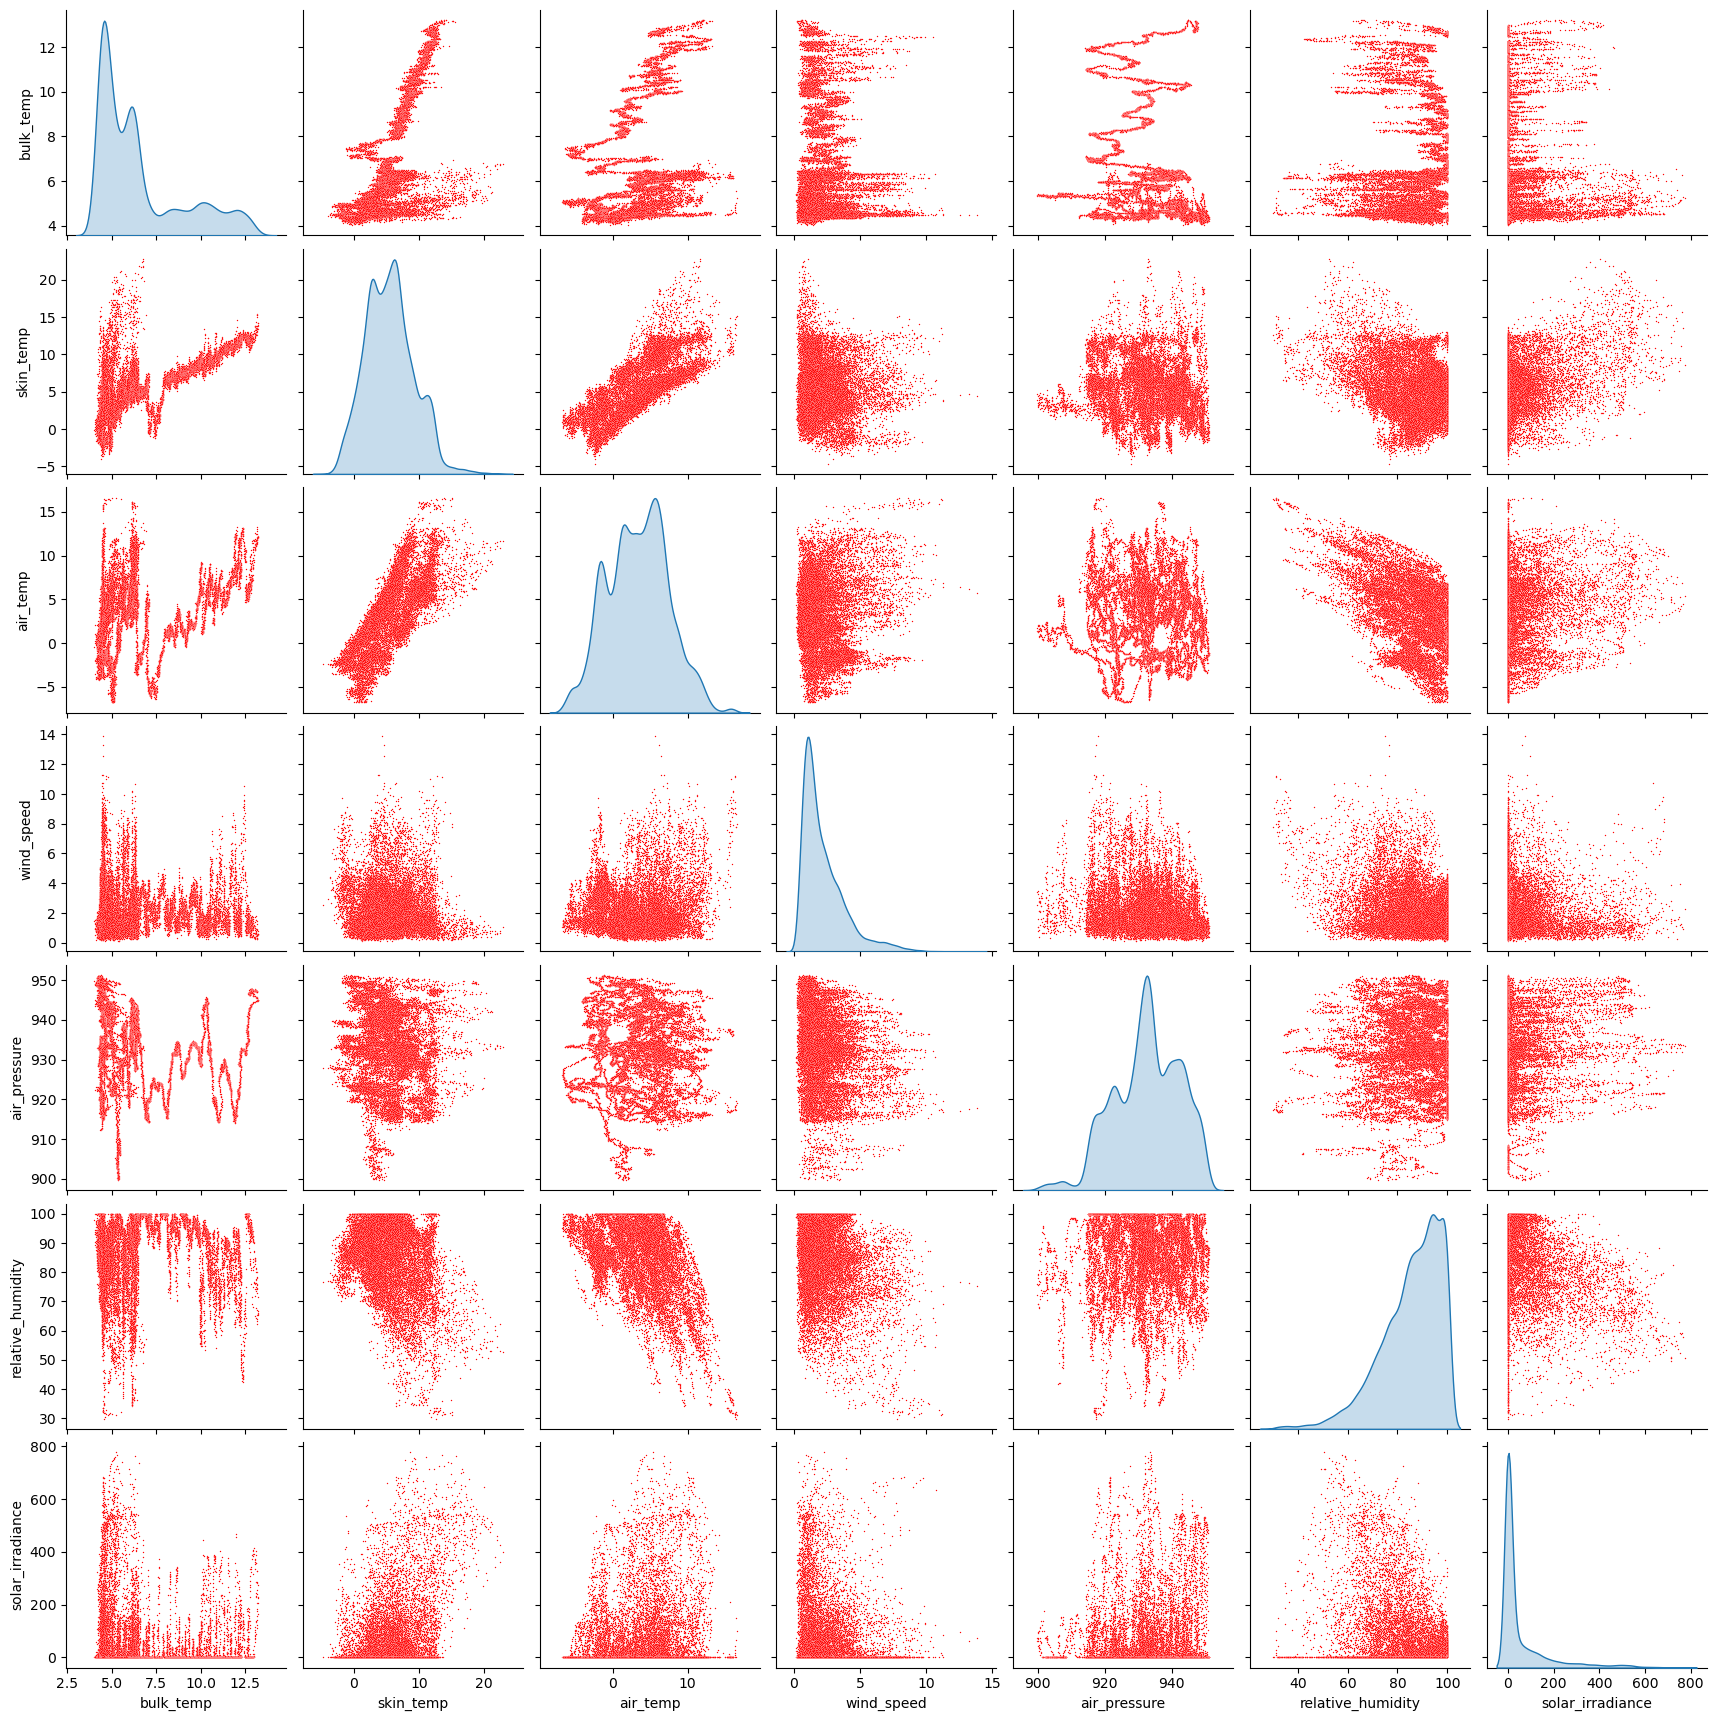

In [12]:
g.create_pairplot(column_names=['bulk_temp', 'skin_temp', 'air_temp', 'wind_speed','air_pressure', 'relative_humidity', 'solar_irradiance'])